In [3]:
"""
Scammed link
https://stackoverflow.com/questions/61136393/keras-pretraining-of-a-cnn-model-and-after-use-it-for-a-cnn-lstm-model

"""
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed,LSTM,Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import load_img, img_to_array,array_to_img
from keras import  models

from batch_data_generator import DataGenerator

2022-10-20 21:26:30.165773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/peshmerge/anaconda3/envs/py3813/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-20 21:26:30.165876: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Global configs for all models

In [4]:
seed_constant = 123
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
# Data paths are defined here
DATA_DIR = 'data'
VIDEO_PATH = os.path.join(DATA_DIR, 'videos')
ANNOTATION_PATH = os.path.join(DATA_DIR, 'annotations')
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation')

In [6]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Set a minimum duration in seconds to extract sequence in multiples of
MIN_DURATION = 150

(DIMENSION_X, DIMENSION_Y, DIMENSION_C) = (224, 224, 3)

# Get the names of all classes/categories in our dataset.
CLASSES_LIST = os.listdir(TRAINING_PATH)

In [7]:
class_mapping = {
'_cut___chop___slice_a_vegetable,_fruit,_or_meat_' : 'cut vegetables, herbs or meat',
'browse_through_clothing_items_on_rack___shelf___hanger' : 'browse through clothing items',
'clean___wipe_other_surface_or_object' : 'clean surface',
'dig_or_till_the_soil_with_a_hoe_or_other_tool' : 'till soil with a hoe',
'read_a_book___magazine___shopping_list_etc' : 'read a book',
'throw_away_trash___put_trash_in_trash_can' : 'throw away trash',
'wash_dishes___utensils___bakeware_etc' : 'wash utensils'}

print(len(CLASSES_LIST))

7


In [8]:
def get_nparray_and_labels_in_partition(partition_path):
	nparrayfile_paths = []
	labels = {}
	for class_name in os.listdir(partition_path):
		if class_name not in CLASSES_LIST:
			print(f'{class_name} not found in class list!')
			continue
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.npy'): continue
			nparrayfile_path = os.path.join(partition_path, class_name, video_file_name)
			nparrayfile_paths.append(nparrayfile_path)
			labels[nparrayfile_path] = CLASSES_LIST.index(class_name)
	return nparrayfile_paths, labels

In [9]:
nparray_partition = {}
nparray_labels = {}
nparray_partition['train'], nparray_labels['train'] = get_nparray_and_labels_in_partition(TRAINING_PATH)
nparray_partition['test'], nparray_labels['test'] = get_nparray_and_labels_in_partition(TESTING_PATH)
nparray_partition['validation'], nparray_labels['validation'] = get_nparray_and_labels_in_partition(VALIDATION_PATH)


train_data_generator_params = {
	'batch_size' : 80,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'batch_size' : 20,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

In [10]:
training_generator = DataGenerator(nparray_partition['train'], nparray_labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(nparray_partition['validation'], nparray_labels['validation'], **validation_data_generator_params)

## 2. Create model - pre-trained CNN (VGG16) + LSTM

In [11]:
def create_CNN_LSTM_model():
    # Define the VGG16 pretrained model without the last two fully conntected layer and the dense layer for 1000 classes
    vgg16_model = VGG16(weights='imagenet',include_top= False,input_shape=(224,224,3))
    # Freeze the base model layers
    vgg16_model.trainable = False
    # Remove the last layer (Softmax) which is doing the prediction for 1000 classes
    vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)
    vgg16_model.summary()
    vgg16_model.trainable = False
    CNN_LSTM_model = Sequential(tf.keras.layers.TimeDistributed(vgg16_model, input_shape=(None, 224, 224, 3)))
    CNN_LSTM_model.add(tf.keras.layers.TimeDistributed(Flatten()))

    CNN_LSTM_model.add(LSTM(32,activation='relu',return_sequences='True'))
    CNN_LSTM_model.add(LSTM(32, activation='relu',return_sequences='False'))
    CNN_LSTM_model.add(Dense(1024, activation="relu"))
    CNN_LSTM_model.add(Dense(len(CLASSES_LIST),activation='softmax'))

    CNN_LSTM_model.summary()
    return CNN_LSTM_model

2022-10-20 21:28:28.221076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 21:28:28.221433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/peshmerge/anaconda3/envs/py3813/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-20 21:28:28.221502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/peshmerge/anaconda3/envs/py3813/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-20 21:28:28.221557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

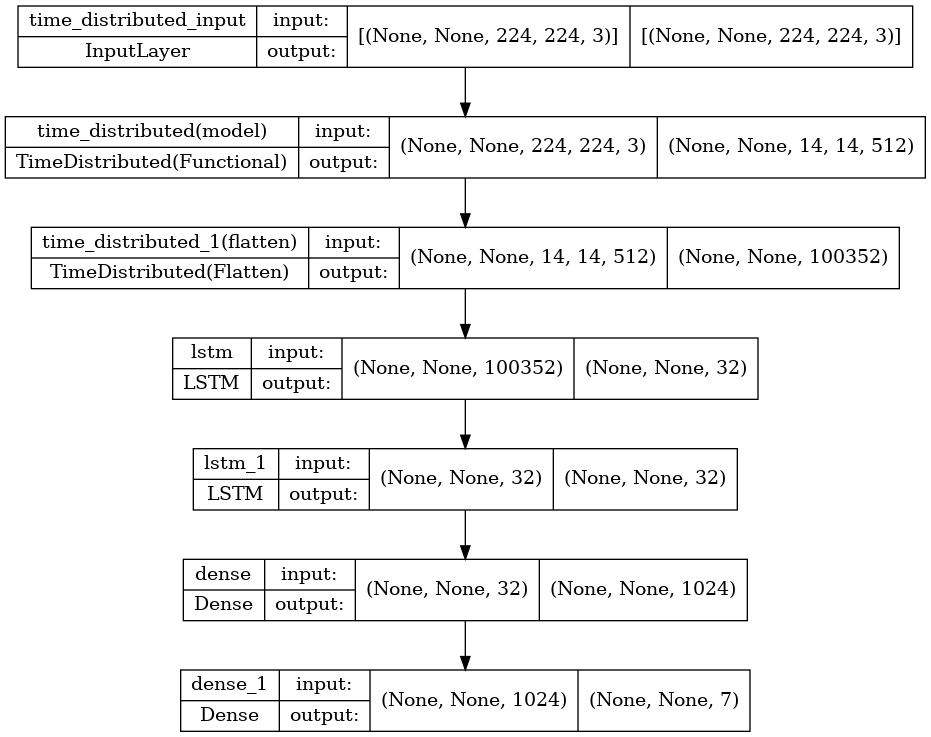

In [12]:
CNN_LSTM_model = create_CNN_LSTM_model()
# Display the success message. 
print("Model Created Successfully!")
plot_model(CNN_LSTM_model, to_file = 'pretrained_cnn_lstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [116]:
%%time
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
CNN_LSTM_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
CNN_LSTM_model_training_history = CNN_LSTM_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=6, 
    epochs = 50,
    callbacks = [early_stopping_callback])

Epoch 1/50


## 3. Create model - (untrained)CNN (VGG16) + LSTM

In [13]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, 224, 224, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model
    

In [19]:
%%time
LRCN_model = create_LRCN_model()
# Display the success message. 
print("Model Created Successfully!")
plot_model(LRCN_model, to_file = 'lrnc_cnn_lstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=6, 
    epochs = 50,
    callbacks = [early_stopping_callback])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 30, 224, 224, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 56, 56, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 56, 56, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 56, 56, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 14, 14, 32)  

2022-10-20 21:23:04.715642: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1445068800 exceeds 10% of free system memory.


Epoch 1/50


## 4. Create model - pre-trained CNN (ResNet50) + LSTM (EXTRA)

In [14]:
def ResNet_pretrained_model(seq_len=30,frames=30,channels=3,img_height=224,img_width=224,n_output=7):
    frames, channels, rows, columns = frames,channels,img_height,img_width
    video = Input(shape=(frames,
                         rows,
                         columns,
                         channels))
    
    cnn_base = ResNet50(input_shape=(rows,
                                  columns,
                                  channels),
                     weights="imagenet",
                     include_top=False)
    
    cnn_base.trainable = False

    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    print(cnn_out)
    
    cnn = Model(cnn_base.input,  cnn_out)
    
    encoded_frames = TimeDistributed(cnn)(video)
    encoded_sequence = LSTM(32)(encoded_frames)
    
    hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
    
    outputs = Dense(n_output, activation="softmax")(hidden_layer)

    model = Model(video, outputs)
    return model

In [15]:
model = ResNet_pretrained_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 224, 224, 3)  0         
                             ]                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 2048)         23587712  
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 32)                266368    
                                                                 
 dense_2 (Dense)             (None, 1024)              33792     
                                                                 
 dense_3 